**Import Libraries/Functions/Data**

In [1]:
#import libraries and functions
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as scipy
import scipy.stats as stats
from datetime import datetime
from scipy.stats import skew 
from scipy.special import boxcox1p
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.style as style 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler 
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor 
import sklearn.linear_model as linear_model
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import missingno as msno 
from sklearn import metrics
from sklearn.datasets import load_iris

In [2]:
#import data
train0 = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv') #1-1460
test0 = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv') #1461-2919

**Data Exploration/Data Cleansing**

In [3]:
# view the train set
train0.info
# sum over rows to get total number of missing values in each column
train0.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [4]:
#view squared correlation of all features to sales price to view potentially significant features
(train0.corr()**2)["SalePrice"].sort_values(ascending = False)[:20]
# Early signs of multicollinearity, i.e Garage Cars and Garage Area

SalePrice       1.000000
OverallQual     0.625652
GrLivArea       0.502149
GarageCars      0.410124
GarageArea      0.388667
TotalBsmtSF     0.376481
1stFlrSF        0.367057
FullBath        0.314344
TotRmsAbvGrd    0.284860
YearBuilt       0.273422
YearRemodAdd    0.257151
GarageYrBlt     0.236548
MasVnrArea      0.228000
Fireplaces      0.218023
BsmtFinSF1      0.149320
LotFrontage     0.123763
WoodDeckSF      0.105244
2ndFlrSF        0.101974
OpenPorchSF     0.099765
HalfBath        0.080717
Name: SalePrice, dtype: float64

In [5]:
#combine the test and train data along axis 0 to stack them on top of each other
pd.concat([train0, test0], axis=0)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


In [6]:
# drop the sales price column from both sets and remove ids from the train data, then 
# redefine sets with changes
target = train0['SalePrice']
test_ids = test0['Id']

train1 = train0.drop(['Id','SalePrice'], axis = 1)
test1 = test0.drop('Id', axis=1)

data1=pd.concat([train1, test1,], axis = 0).reset_index(drop=True)


In [7]:
#Investigate Numeric Columns
data1.select_dtypes(np.number)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,548.0,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,460.0,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,608.0,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,642.0,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,836.0,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,21.0,1936,4,7,1970,1970,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,6,2006
2915,160,21.0,1894,4,5,1970,1970,0.0,252.0,0.0,...,286.0,0,24,0,0,0,0,0,4,2006
2916,20,160.0,20000,5,7,1960,1996,0.0,1224.0,0.0,...,576.0,474,0,0,0,0,0,0,9,2006
2917,85,62.0,10441,5,5,1992,1992,0.0,337.0,0.0,...,0.0,80,32,0,0,0,0,700,7,2006


In [8]:
#investigate 'MSSubClass' further
data1['MSSubClass']

0        60
1        20
2        60
3        70
4        60
       ... 
2914    160
2915    160
2916     20
2917     85
2918     60
Name: MSSubClass, Length: 2919, dtype: int64

In [9]:
#Need to convert MSSubClass from numerical to string as data desc shows this is categorical
data1['MSSubClass'] = data1['MSSubClass'].astype(str)

*Dealing WIth Missing Categorical Values*

In [10]:
# Investigate each column and determine whether missing values need to be filled with the 
# mode or some other constant.

data1.select_dtypes('object').loc[:, data1.isna().sum() > 0].columns

Index(['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType'],
      dtype='object')

In [11]:
#Impute using a constant value
for column in [
    'Alley',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'FireplaceQu',
    'GarageType',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence',
    'MiscFeature',
]:
    data1[column] = data1[column].fillna('None')

    #Impute using the mode
for column in [
    'MSZoning',
    'Utilities',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Electrical',
    'KitchenQual',
    'Functional',
    'SaleType'
    
]:
    data1[column] = data1[column].fillna(data1[column].mode()[0])

In [12]:
#check updates on categorical columns
data1.select_dtypes('object').isna().sum().sum()

0

*Dealing With Missing Numerical Variables*

In [13]:
# run missing values check on numerical columns
data1.select_dtypes(np.number).isna().sum()

LotFrontage      486
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       2
BsmtHalfBath       2
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt      159
GarageCars         1
GarageArea         1
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

In [14]:
# creating a knn regressor to fill missing numerical values
def knn_impute(df, na_target):
    df = df.copy()

    numeric_df = df.select_dtypes(np.number)
    non_na_columns = numeric_df.loc[: ,numeric_df.isna().sum() == 0].columns

    y_train = numeric_df.loc[numeric_df[na_target].isna() == False, na_target]
    x_train = numeric_df.loc[numeric_df[na_target].isna() == False, non_na_columns]
    x_test = numeric_df.loc[numeric_df[na_target].isna() == True, non_na_columns]

    knn = KNeighborsRegressor()
    knn.fit(x_train, y_train)

    y_pred = knn.predict(x_test)

    df.loc[df[na_target].isna() == True, na_target] = y_pred

    return df

In [15]:
#check all columns that still have multiple missing values
data1.columns[data1.isna().sum() > 0]

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea'],
      dtype='object')

In [16]:
# apply the KNNRegressor to this list
for column in [
    'LotFrontage',
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea',
]:
    data1 = knn_impute(data1, column)


In [17]:
#run the missing values list again
data1.isna().sum().sum()


0

**Feature Transformation**

*Exploring Distribution*

In [18]:
# create a data frame which lists all numberical variables titled Variable
skew_df = pd.DataFrame(data1.select_dtypes(np.number).columns, columns=['Variable'])
# get the skew value for each variable 
skew_df['skew'] = skew_df['Variable'].apply(lambda variable: scipy.stats.skew(data1[variable]))
# convert to positive/absolute value 
skew_df['Absolute Skew'] = skew_df['skew'].apply(abs)
# create true/false column to see whether shew value is above 0.5
skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)
# select all columns that are skewed
skew_df.query("Skewed == True")["Variable"]

0       LotFrontage
1           LotArea
3       OverallCond
4         YearBuilt
6        MasVnrArea
7        BsmtFinSF1
8        BsmtFinSF2
9         BsmtUnfSF
10      TotalBsmtSF
11         1stFlrSF
12         2ndFlrSF
13     LowQualFinSF
14        GrLivArea
15     BsmtFullBath
16     BsmtHalfBath
18         HalfBath
20     KitchenAbvGr
21     TotRmsAbvGrd
22       Fireplaces
26       WoodDeckSF
27      OpenPorchSF
28    EnclosedPorch
29        3SsnPorch
30      ScreenPorch
31         PoolArea
32          MiscVal
Name: Variable, dtype: object

*Apply Log Transformation to Normalise Distribution*

In [19]:
#Evaluate values of remaining skewed columns
data1[skew_df.query("Skewed == True")['Variable'].values].describe()

,LotFrontage,LotArea,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,70.154916,10168.114080,5.564577,1971.312778,102.189654,441.332580,49.576841,560.797670,1051.679822,1159.581706,...,1.044536,6.451524,0.597122,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968
std,22.697641,7886.996359,1.113131,30.291442,178.934095,455.559081,169.176867,439.470508,440.722380,392.362079,...,0.214462,1.569379,0.646129,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211
min,21.000000,1300.000000,1.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,7478.000000,5.000000,1953.500000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,...,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,70.000000,9453.000000,5.000000,1973.000000,0.000000,368.000000,0.000000,467.000000,989.000000,1082.000000,...,1.000000,6.000000,1.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,80.100000,11570.000000,6.000000,2001.000000,164.000000,733.000000,0.000000,805.000000,1302.000000,1387.500000,...,1.000000,7.000000,1.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,313.000000,215245.000000,9.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,...,3.000000,15.000000,4.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000


In [20]:
for column in skew_df.query("Skewed == True")['Variable'].values:
    data1[column] = np.log1p(data1[column])

In [21]:
# apply Cosine Feature transformation to reflect cyclical nature of months
-np.cos(0.5236 * data1['MoSold'])

0      -0.499998
1       0.866028
2      -0.000011
3      -0.499998
4      -1.000000
          ...   
2914    1.000000
2915    0.500004
2916   -0.000011
2917    0.866021
2918   -0.866032
Name: MoSold, Length: 2919, dtype: float64

In [22]:
#set this equal to the new feature
data1['MoSold'] = -np.cos(0.5236 * data1['MoSold'])


**Encoding**

In [23]:
#Apply one-hot encoding to all categorical variables
data1 = pd.get_dummies(data1)

**Scaling**

In [24]:
# Make a copy of current dataset
data2 = data1.copy()
#Apply standard scale transformation, centering all variables at 0 with a variance of 1
scaler = StandardScaler()
scaler.fit(data2)
data2 = pd.DataFrame(scaler.transform(data2), index=data2.index, columns=data2.columns)

In [25]:
data2

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.064176,-0.103719,0.646183,-0.435439,1.040634,0.896833,1.210174,0.783229,-0.363076,-0.326949,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
1,0.536077,0.146544,-0.063185,1.906370,0.161526,-0.395604,-0.804554,0.892444,-0.363076,0.013428,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2,0.066112,0.457629,0.646183,-0.435439,0.975922,0.848965,1.137926,0.658154,-0.363076,0.240016,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
3,-0.295084,0.136301,0.646183,-0.435439,-1.869638,-0.682812,-0.804554,0.386923,-0.363076,0.356870,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
4,0.677357,0.922662,1.355551,-0.435439,0.943542,0.753229,1.430432,0.758108,-0.363076,0.304906,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-3.284214,-2.993401,-1.481920,1.226101,-0.035461,-0.682812,-0.804554,-1.418196,-0.363076,0.362780,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693
2915,-3.284214,-3.036401,-1.481920,-0.435439,-0.035461,-0.682812,-0.804554,0.438424,-0.363076,0.031907,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
2916,2.549545,1.586172,-0.772552,1.226101,-0.365110,0.561757,-0.804554,0.967658,-0.363076,-3.015455,...,-0.052423,-0.298629,-0.049029,0.394439,3.789876,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693
2917,-0.200527,0.311255,-0.772552,-0.435439,0.683917,0.370284,-0.804554,0.535612,-0.363076,0.390461,...,-0.052423,-0.298629,-0.049029,0.394439,-0.263861,-0.064249,-0.09105,-0.126535,0.463937,-0.302693


**Target Transformation**

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


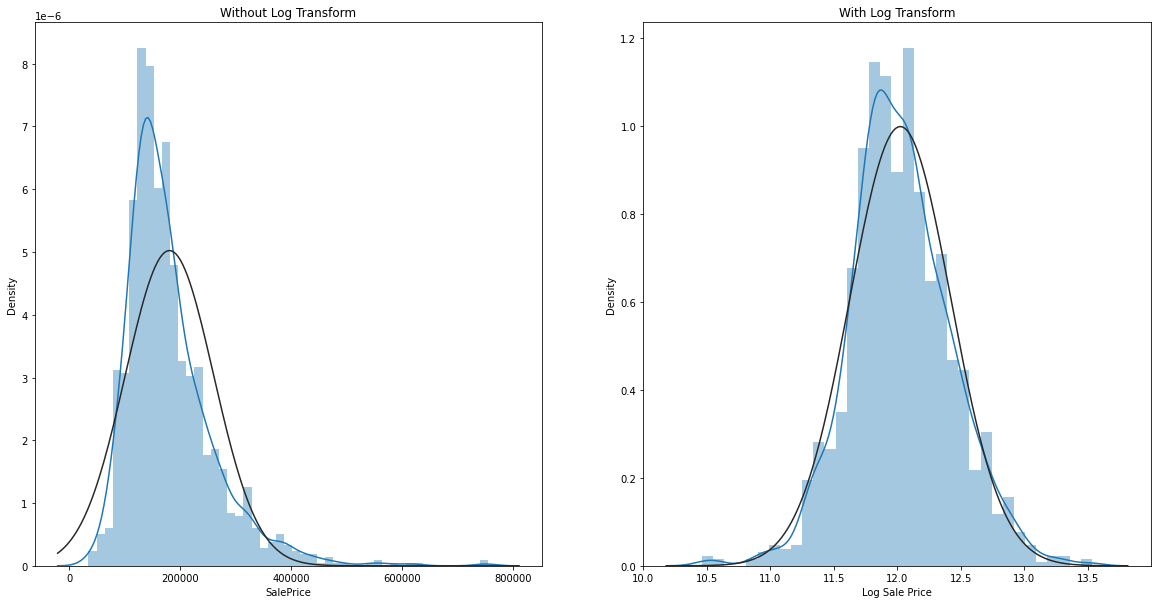

In [26]:
plt.figure(figsize=(20, 10))

plt.subplot(1 ,2, 1)
sns.distplot(target, kde=True, fit=scipy.stats.norm)
plt.title("Without Log Transform")

plt.subplot(1 ,2, 2)
sns.distplot(np.log(target), kde=True, fit=scipy.stats.norm)
plt.xlabel("Log Sale Price")
plt.title("With Log Transform")

plt.show()

In [27]:
log_target = np.log(target)
np.exp(log_target)

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
1455    175000.0
1456    210000.0
1457    266500.0
1458    142125.0
1459    147500.0
Name: SalePrice, Length: 1460, dtype: float64

**Split the train and test data**

In [28]:
train_final = data2.loc[:train0.index.max(), :].copy()
test_final = data2.loc[train0.index.max() + 1:, :].reset_index(drop=True).copy()

In [29]:
x_train = train_final
y_train = train0['SalePrice']

In [30]:
# apply xgboost regressor
import xgboost
classifier=xgboost.XGBRegressor()
classifier.fit(x_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [31]:
y_pred=classifier.predict(test_final)

In [32]:
y_pred

array([126552.54, 159018.17, 185009.02, ..., 171390.33, 110372.22,
       209576.81], dtype=float32)

In [33]:
#Create Sample Submission File and Submit
pred=pd.DataFrame(y_pred)
sub_data=pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
datasets=pd.concat([sub_data['Id'],pred],axis=1)
datasets.columns=['Id','SalePrice']
datasets.to_csv('sample_submission.csv',index=False)